In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
from sophius.db import *
from peewee import *
import pandas as pd

query = (Runs
         .select(Runs.id.alias('run_id'), Runs, Models, Devices.name.alias('dev_name'))
         .where(Runs.exp_id==1)
         .join(Models)
         .switch(Runs)
         .join(Devices)
         .dicts())

cols = ['run_id', 'hash', 'flops', 'params', 'val_acc', 'train_acc', 'time', 'dev_name']
df = pd.DataFrame(query)[cols]
df.time = df.time.round()

# df = pd.DataFrame(query)

df

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name
0,1,0080810a080800000049200001000000,2053728,145642,0.663141,0.865986,14.0,NVIDIA GeForce RTX 4090
1,2,00880406200000000024a80001000000,30624,954,0.399900,0.405278,14.0,NVIDIA GeForce RTX 4090
2,3,0080804520000000400000000023300001000000,1437216,29770,0.642238,0.700962,14.0,NVIDIA GeForce RTX 4090
3,4,0080421210080000400000000010000001000000,3738752,7818,0.479167,0.488632,17.0,NVIDIA GeForce RTX 4090
4,5,008402112000000000485000400000000010000001000000,357920,986,0.436639,0.439653,18.0,NVIDIA GeForce RTX 4090
...,...,...,...,...,...,...,...,...
8848,8859,0080442120000000400000000022c80000804412080400...,32131840,959755,0.758193,0.999900,178.0,Quadro RTX 6000
8849,8860,0080482120000000004310004000000000808809100200...,15712800,578090,0.748337,0.999700,121.0,Quadro RTX 6000
8850,8861,0080442120000000400000000080812108040000004890...,424314048,559979,0.745443,0.999800,209.0,Quadro RTX 6000
8851,8862,008800a220000000004320004000000000880822200000...,12173312,424547,0.643339,0.907432,130.0,Quadro RTX 6000


In [3]:
df['len'] = df.hash.apply(len)
df.sort_values(by=['len', 'val_acc'], ascending=[True, False])

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name,len
530,531,008042110804000001000000,3398400,294283,0.644401,0.950270,17.0,NVIDIA GeForce RTX 4090,24
864,865,0080810a0804000001000000,1997952,123467,0.641236,0.885106,15.0,NVIDIA GeForce RTX 4090,24
442,443,0080204a0808000001000000,7341312,260938,0.639073,0.965986,14.0,NVIDIA GeForce RTX 4090,24
1006,1007,008020850804000001000000,2239104,115019,0.636889,0.882021,14.0,NVIDIA GeForce RTX 4090,24
3841,3842,008021110808000001000000,6472704,391114,0.636609,0.974419,15.0,NVIDIA GeForce RTX 4090,24
...,...,...,...,...,...,...,...,...,...
8278,8279,00820061080400004000000000292800008080a1080800...,385514136,1023284,0.737710,0.969852,172.0,NVIDIA GeForce RTX 4090,288
4719,4720,0082010908080000004510004000000000292800008401...,1382664,402453,0.616687,0.694151,79.0,NVIDIA GeForce RTX 4090,296
2186,2187,00841012080400000042a0004000000000810212100400...,1580960,375563,0.540835,0.627955,79.0,NVIDIA GeForce RTX 4090,296
3134,3135,0080281120000000400000000023300000804811080800...,18741728,1270323,0.666747,0.970292,87.0,NVIDIA GeForce RTX 4090,320


In [63]:
from sophius.encode import Encoder

encoder = Encoder()
encoder.hash2model('00810422080400000049200040000000008080a1080800000042900040000000002350000080212120000000004910000024b000200000000045100001000000', (3, 32, 32), 10)

Conv2d       (64, 32, 32)   (3, 3)   (1, 1)  
PReLU        (64, 32, 32)  
MaxPool2d    (64, 33, 33)   (2, 2)   (1, 1)  
BatchNorm2d  (64, 33, 33)  
Conv2d       (96, 28, 28)   (6, 6)   (1, 1)  
PReLU        (96, 28, 28)  
MaxPool2d    (96, 13, 13)   (4, 4)   (2, 2)  
BatchNorm2d  (96, 13, 13)  
AvgPool2d    (96, 14, 14)   (4, 4)   (1, 1)  
Conv2d       (192, 10, 10)  (5, 5)   (1, 1)  
ReLU         (192, 10, 10) 
MaxPool2d    (192, 9, 9)    (2, 2)   (1, 1)  
AvgPool2d    (192, 4, 4)    (3, 3)   (2, 2)  
ReLU         (192, 4, 4)   
MaxPool2d    (192, 2, 2)    (3, 3)   (1, 1)  
Flatten      768           
Linear       10            

In [5]:
from sophius.modelgen import ConvModelGenerator
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=1, lin_num=1)
t = model_gen.generate_model_tmpl()
print(t)
encoder.model2hash(t)

Conv2d       (32, 17, 17)   (6, 6)   (2, 2)  
PReLU        (32, 17, 17)  
BatchNorm2d  (32, 17, 17)  
AvgPool2d    (32, 18, 18)   (4, 4)   (1, 1)  
Flatten      10368         
Linear       10            



'0082009208080000400000000023500001000000'

In [6]:
import torch
from sophius.estimate import LSTMRegressor
from sophius.utils import calc_model_flops
from sophius.estimate import Estimator


estimator = Estimator()

In [64]:
from sophius.templates import Conv2dTmpl, ReLUTmpl, GlobalAvgPool2dTmpl, LinearTmpl, ModelTmpl, FlattenTmpl, \
    MaxPool2dTmpl, PReLUTmpl, BatchNorm2dTmpl
from sophius.utils import calc_model_flops

templates = [
    Conv2dTmpl(out_channels=192, kernel_size=(3, 3), stride=(1, 1)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),

    Conv2dTmpl(out_channels=192, kernel_size=(3, 3), stride=(1, 1)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),

    Conv2dTmpl(out_channels=192, kernel_size=(3, 3), stride=(1, 1)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),

    FlattenTmpl(),
    LinearTmpl(),
]

print(t)
print(calc_model_flops(t.instantiate_model(), t.in_shape))
print('val_acc*', round(estimator.predict_val_acc(t), 3))

Conv2d       (64, 32, 32)   (3, 3)   (1, 1)  
PReLU        (64, 32, 32)  
MaxPool2d    (64, 33, 33)   (2, 2)   (1, 1)  
BatchNorm2d  (64, 33, 33)  
Conv2d       (96, 28, 28)   (6, 6)   (1, 1)  
PReLU        (96, 28, 28)  
MaxPool2d    (96, 13, 13)   (4, 4)   (2, 2)  
BatchNorm2d  (96, 13, 13)  
AvgPool2d    (96, 14, 14)   (4, 4)   (1, 1)  
Conv2d       (192, 10, 10)  (5, 5)   (1, 1)  
ReLU         (192, 10, 10) 
MaxPool2d    (192, 9, 9)    (2, 2)   (1, 1)  
AvgPool2d    (192, 4, 4)    (3, 3)   (2, 2)  
ReLU         (192, 4, 4)   
MaxPool2d    (192, 2, 2)    (3, 3)   (1, 1)  
Flatten      768           
Linear       10            

{'flops': 443220576, 'macs': 221265408, 'params': 692171}
val_acc* 0.75


In [35]:
from sophius.train import train_on_gpu_ex
from sophius.dataload import load_cifar_gpu

cifar_gpu = load_cifar_gpu()

Files already downloaded and verified



Loss 0.061: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


val_acc: 0.686 train_acc: 0.999


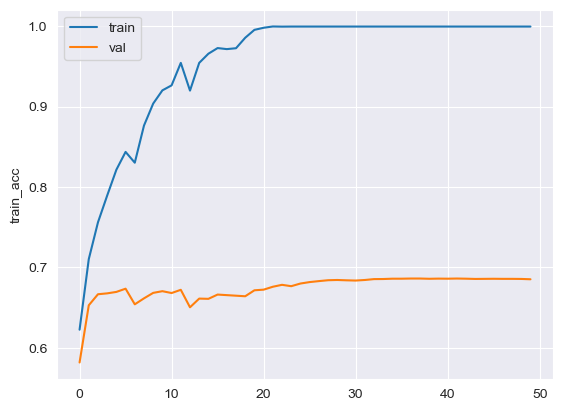

In [44]:
import seaborn as sns

templates = [
    Conv2dTmpl(out_channels=32, kernel_size=(3, 3), stride=(2, 2)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),

    Conv2dTmpl(out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),

    Conv2dTmpl(out_channels=128, kernel_size=(3, 3), stride=(2, 2)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),

    FlattenTmpl(),
    LinearTmpl(),
]

t = ModelTmpl((3, 32, 32), 10, *templates)

params = {
    'verbose': True,
    'batch_size': 256,
    'num_epoch': 50,
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },    
}

res = train_on_gpu_ex(t.instantiate_model().cuda(), cifar_gpu, **params)

print(t)
print(calc_model_flops(t.instantiate_model(), t.in_shape))
print('val_acc*', round(estimator.predict_val_acc(t), 3))

sns.lineplot(res['train_acc'], label='train')
sns.lineplot(res['val_acc'], label='val');

Conv2d       (32, 16, 16)   (3, 3)   (2, 2)  
BatchNorm2d  (32, 16, 16)  
ReLU         (32, 16, 16)  
Conv2d       (64, 16, 16)   (3, 3)   (1, 1)  
BatchNorm2d  (64, 16, 16)  
ReLU         (64, 16, 16)  
Conv2d       (128, 8, 8)    (3, 3)   (2, 2)  
BatchNorm2d  (128, 8, 8)   
ReLU         (128, 8, 8)   
Flatten      8192          
Linear       10            

{'flops': 19611648, 'macs': 9740288, 'params': 175626}
val_acc* 0.685



Loss 0.145: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


val_acc: 0.619 train_acc: 0.999
Conv2d       (32, 16, 16)   (3, 3)   (2, 2)  
BatchNorm2d  (32, 16, 16)  
ReLU         (32, 16, 16)  
Conv2d       (64, 16, 16)   (3, 3)   (1, 1)  
BatchNorm2d  (64, 16, 16)  
ReLU         (64, 16, 16)  
Conv2d       (64, 16, 16)   (1, 1)   (1, 1)  
BatchNorm2d  (64, 16, 16)  
ReLU         (64, 16, 16)  
Conv2d       (128, 8, 8)    (3, 3)   (2, 2)  
BatchNorm2d  (128, 8, 8)   
ReLU         (128, 8, 8)   
Conv2d       (128, 8, 8)    (1, 1)   (1, 1)  
BatchNorm2d  (128, 8, 8)   
ReLU         (128, 8, 8)   
Flatten      8192          
Linear       10            



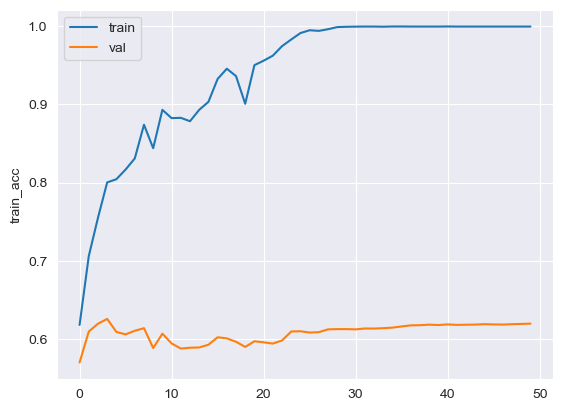

In [43]:
templates = [
    Conv2dTmpl(out_channels=32, kernel_size=(3, 3), stride=(2, 2)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),
    # Conv2dTmpl(out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
    # BatchNorm2dTmpl(),
    # ReLUTmpl(),
    
    # MobileNet Block
    Conv2dTmpl(out_channels=64, kernel_size=(3, 3), stride=(1, 1), groups=32),
    BatchNorm2dTmpl(),
    ReLUTmpl(),
    Conv2dTmpl(out_channels=64, kernel_size=(1, 1), stride=(1, 1)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),

    # MobileNet Block
    Conv2dTmpl(out_channels=128, kernel_size=(3, 3), stride=(2, 2), groups=32),
    BatchNorm2dTmpl(),
    ReLUTmpl(),
    Conv2dTmpl(out_channels=128, kernel_size=(1, 1), stride=(1, 1)),
    BatchNorm2dTmpl(),
    ReLUTmpl(),
    
    FlattenTmpl(),
    LinearTmpl(),
]

t = ModelTmpl((3, 32, 32), 10, *templates)

params = {
    'verbose': True,
    'batch_size': 256,
    'num_epoch': 50,
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },    
}

res = train_on_gpu_ex(t.instantiate_model().cuda(), cifar_gpu, **params)
print(t)
sns.lineplot(res['train_acc'], label='train')
sns.lineplot(res['val_acc'], label='val');

In [8]:
df['pred_val_acc'] = (df.hash
                      .apply(encoder.hash2model, in_shape=(3, 32, 32), out_shape=10)
                      .apply(estimator.predict_val_acc))

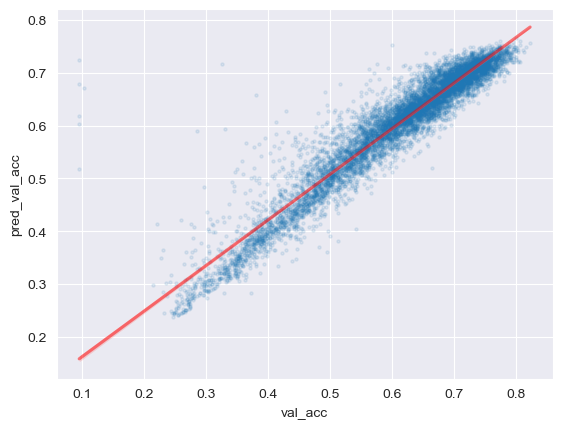

In [9]:
import seaborn as sns

sns.regplot(df, x='val_acc', y='pred_val_acc', scatter_kws={'alpha': 0.1, 's': 5}, line_kws={'color': 'red', 'alpha': 0.5});